In [2]:
# std packages
%matplotlib inline
import numpy as np
import scipy.interpolate as interp
import scipy.signal as sig
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.linalg as sla
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import h5py as h5

plt.rc('figure', figsize=(9, 7))
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': False,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 17,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

from myConstants import *

In [3]:
def get_inst_t_gw_from_a_orb(M1, M2, a_orb, e):
    Mt=M1+M2
    mu=M1*M2/(M1+M2)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c
    
    inv_t_gw = (64./5.)*(G3muMt2_c5a3/a_orb) \
                * (1.+73./24.*e**2+37./96.*e**4.)/(1.-e**2.)**(3.5)
    t_gw = 1./inv_t_gw
    return t_gw

def evol_log_aL(t_nat, logy_vect, par_aL):
    loga, logL = logy_vect
    M1, M2, t_unit= par_aL
    Mt=M1+M2
    mu=M1*M2/Mt
    
    a_orb = np.exp(loga)
    L_orb = np.exp(logL)
    eff = L_orb/(mu*np.sqrt(G*Mt*a_orb))
    e_orb = np.sqrt(1.-eff**2.)
    
    G3_c5 = G**3./c**5.
    e2 = e_orb**2.
    e4 = e_orb**4.
    
    da = - (64./5.*G3_c5) * (mu*(M1+M2)**2./(a_orb**3.))\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3_c5*np.sqrt(G)) * mu**2.*(M1+M2)**2.5 / (a_orb**3.5) \
          * (1.+0.875*e2)/(eff**4.)
    
    dlogy_vect = np.array([da/a_orb, dL/L_orb]) * t_unit
    return dlogy_vect

def evol_logL_vs_loga(loga_Mt, logL_Mt, par_aL):
    M1, M2= par_aL
    Mt=M1+M2
    mu=M1*M2/Mt
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    a_orb = np.exp(loga_Mt)*r_Mt
    L_orb = np.exp(logL_Mt)*S_Mt
    eff = L_orb/(mu*np.sqrt(G*Mt*a_orb))
    e_orb = np.sqrt(1.-eff**2.)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c #G**3.*mu*Mt**2./c**5./a_orb**3.
    e2 = e_orb**2.
    e4 = e_orb**4.
    
    da = - (64./5.) * (G3muMt2_c5a3)\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3muMt2_c5a3*np.sqrt(G)) * mu *np.sqrt(M1+M2) / np.sqrt(a_orb) \
          * (1.+0.875*e2)/(eff**4.)
    
    dLda = dL/da
    dlogL_dloga = a_orb/L_orb * dL/da
    return dlogL_dloga

def get_angles(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    
    c_th1 = 0.5 * 1./((1.-qq)*S1) * \
        ((J**2. - L**2. - S**2.)/L  - 2.*qq*G*Mt**2./c*chi_eff/(1.+qq))
    c_th2 = 0.5 * qq/((1.-qq)*S2) * \
        (-(J**2.-L**2.-S**2.)/L + 2.*G*Mt**2./c*chi_eff/(1.+qq))
    c_th12 = (S**2. - S1**2. -S2**2.)/(2.*S1*S2)
    
    th1, th2, th12 = np.arccos(c_th1), np.arccos(c_th2), np.arccos(c_th12)
    c_dphi = (c_th12 - c_th1*c_th2)/(np.sin(th1) * np.sin(th2))
    dphi = np.arccos(c_dphi)
    return th1, th2, th12, dphi

def get_dSdt(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    mu=M1*M2/Mt
    eta=mu/Mt
    eff = np.sqrt(1.-e**2.)
    
    th1, th2, th12, dphi = get_angles(J, L, e, S, par)
    
    dSdt = 1.5*eta**6. * eff**3. * (1-qq**2.)/qq * ((G*Mt**2./c)/L)**5.\
        * (c**3./G/Mt) * (S1*S2/S)\
        * (-1. + 0.5*qq/(1.-qq)**2.*(J**2.-L**2.-S**2.)/L**2. \
          - 2.*qq**2./(1.-qq**2.)**2.*G*Mt**2./c/L*chi_eff)\
        * np.sin(th1) * np.sin(th2) * np.sin(dphi)
    return dSdt

def find_Smp(J, L, e, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    # note here is S vs chi-chi_eff!
    chi_vs_S_func1 = interp.interp1d(S_vect, chi_vect1-chi_eff)
    chi_vs_S_func2 = interp.interp1d(S_vect, chi_vect2-chi_eff)
    
    idx1 = np.argmin(chi_vect1)
    idx2 = np.argmax(chi_vect2)
    
    if np.max(chi_vect1) < chi_eff:
        Sm = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
        Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
    elif np.min(chi_vect2) > chi_eff:
        Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        Sp = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
    else:
        try:
            Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        except ValueError:
            Sm = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
        try:
            Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
        except ValueError:
            Sp = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
            
    if Sm>Sp:
        Sm, Sp = Sp, Sm
    return Sm, Sp

def find_S_chi_contour(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    return S_vect, chi_vect1, chi_vect2
    

def get_tau_pre(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par

    Sm, Sp = find_Smp(J, L, e, par)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = get_dSdt(J, L, e, S_vect, par)
    tau_pre = 2.*integ.trapz(1./np.abs(dSdt_vect), S_vect)
    return tau_pre    

def evol_J_avg(L_nat, J_nat, e_vs_L_func, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    L=L_nat * S_Mt
    J=J_nat * S_Mt
    e_orb = e_vs_L_func(L)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
    tau = 2.*integ.trapz(S_Mt/dSdt_vect, S_vect/S_Mt)
    dJdL = 2./tau * integ.trapz(S_Mt*c_th_L/dSdt_vect, S_vect/S_Mt)
    return dJdL

def evol_J_avg_backup(L_nat, J_nat, e_vs_L_func, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    mu=M1*M2/Mt
    eta = M1*M2/Mt**2.
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    L=L_nat * S_Mt
    J=J_nat * S_Mt
    
    e_orb = e_vs_L_func(L)
    a_orb = L**2./(G*mu**2.*Mt*(1.-e_orb**2.))
    
    t_gw = get_inst_t_gw_from_a_orb(M1, M2, a_orb, e_orb)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    inv_t_pre = np.abs(dSdt_vect/(S_vect+1.e-9*np.ones(nPt)*S_Mt))
    if False:#np.min(inv_t_pre)<(.25/t_gw):
        idx = np.argmin(inv_t_pre)
        S = S_vect[idx]
        c_th_L = (J**2.+L**2.-S**2.)/(2*J*L)
        dJdL = c_th_L
    else:
        c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
        tau = 2.*integ.trapz(S_Mt/dSdt_vect, S_vect/S_Mt)
        dJdL = 2./tau * integ.trapz(S_Mt*c_th_L/dSdt_vect, S_vect/S_Mt)
    return dJdL

In [5]:
M1, M2=30.*Ms, 20.*Ms
Mt = M1+M2
mu_i = M1*M2/(M1+M2)
qq=M2/M1
eta = mu_i/Mt

chi1, chi2 = 0.7, 0.7
S1 = chi1 * G*M1**2./c
S2 = chi2 * G*M2**2./c
chi_eff = 0.002375384418909089

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c

## quantities at the end of the LK run
a_LK=10.*AU
L_LK=38.661643599496365 * S_Mt
J_LK=38.66475235663297 * S_Mt

# e_LK=ei[-1]
eff_LK = L_LK/(mu_i*np.sqrt(G*(M1+M2)*a_LK))
e_LK = np.sqrt(1. - eff_LK**2.)

t_GW_LK = get_inst_t_gw_from_a_orb(M1, M2, a_LK, e_LK) 
print('t_GW when a=a0/10: [yr]', t_GW_LK/P_yr)
print('a/AU, e', a_LK/AU, e_LK)
print('chi_eff', chi_eff)
print('L/Mt^2, J/Mt^2', L_LK/S_Mt, J_LK/S_Mt)

par_aL = np.array([M1, M2])

int_func=lambda loga_, logL_:\
    evol_logL_vs_loga(loga_, logL_, par_aL)
    
sol=integ.solve_ivp(int_func, \
        t_span=(np.log(a_LK/r_Mt), np.log(6.)), y0=np.array([np.log(L_LK/S_Mt)]), rtol=3e-14, atol=1e-14)

a_scal = np.exp(sol.t)*r_Mt
L_scal = np.exp(sol.y[0, :])*S_Mt
eff_scal = L_scal/(mu_i*np.sqrt(G*(M1+M2)*a_scal))
e_scal = np.sqrt(1. - eff_scal**2.)

print(L_scal[-1]/S_Mt)

loge_vs_logL_tck = interp.splrep(np.log(L_scal[::-1]), np.log(e_scal[::-1]))
logL_vs_loga_tck = interp.splrep(np.log(a_scal[::-1]), np.log(L_scal[::-1]))
e_vs_L_func=lambda LL: np.exp(interp.splev(np.log(LL), loge_vs_logL_tck))
L_vs_a_func=lambda aa: np.exp(interp.splev(np.log(aa), logL_vs_loga_tck))

t_GW when a=a0/10: [yr] 7279370.702044483
a/AU, e 10.0 0.9993594198191508
chi_eff 0.002375384418909089
L/Mt^2, J/Mt^2 38.661643599496365 38.66475235663297
0.5878775382666184


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in sqrt


In [26]:
nPt = 50
par_JL = np.array([M1, M2, S1, S2, chi_eff])
int_func=lambda L_nat_, J_nat_:\
    evol_J_avg(L_nat_, J_nat_, e_vs_L_func, par_JL, nPt=nPt)

L_1kM = L_vs_a_func(1000.*r_Mt)
e_1kM = e_vs_L_func(L_1kM)
sol=integ.solve_ivp(int_func, \
    t_span=(L_LK/S_Mt, L_1kM/S_Mt), y0=np.array([J_LK/S_Mt]), rtol=3e-12, atol=1e-12)

J_1kM = sol.y[0,-1] * S_Mt
print('r = 1000 M')
print('J, L, e', J_1kM/S_Mt, L_1kM/S_Mt, e_1kM)

Sm_1kM, Sp_1kM=find_Smp(J_1kM, L_1kM, e_1kM, par_JL)

r = 1000 M
J, L, e 7.596467347144305 7.589278177517016 0.00704246106694598


In [39]:
L_isco = L_vs_a_func(6.*r_Mt)
e_isco = e_vs_L_func(L_isco)
sol=integ.solve_ivp(int_func, \
    t_span=(L_LK/S_Mt, L_isco/S_Mt), y0=np.array([J_LK/S_Mt]), rtol=3e-14, atol=1e-17)

J_isco = sol.y[0,-1] * S_Mt
print('r = 6 M')
print('J, L, e', J_isco/S_Mt, L_isco/S_Mt, e_isco)

Sm_isco, Sp_isco=find_Smp(J_isco, L_isco, e_isco, par_JL)

r = 6 M
J, L, e 0.6477662101346524 0.5878775382666179 2.1385113240373448e-06


In [47]:
LL, JJ = sol.t*S_Mt, sol.y[0, :]*S_Mt
ee = e_vs_L_func(LL)
aa = LL**2./(mu_i**2.*G*(M1+M2)*(1.-ee**2.))
nLL = len(LL)

dJdL, dJdLm, dJdLp = np.zeros(nLL), np.zeros(nLL), np.zeros(nLL)
t_pre, t_pre_m, t_pre_p = np.zeros(nLL), np.zeros(nLL), np.zeros(nLL)
t_gw = np.zeros(nLL)
for i in range(nLL):
    dJdL[i] = int_func(LL[i]/S_Mt, JJ[i]/S_Mt)
    
    SSm, SSp = find_Smp(JJ[i], LL[i], ee[i], par_JL, nPt)
    dJdLm[i] = (JJ[i]**2. + LL[i]**2. - SSm**2.)/(2.*JJ[i]*LL[i])
    dJdLp[i] = (JJ[i]**2. + LL[i]**2. - SSp**2.)/(2.*JJ[i]*LL[i])
    
    dSdt_m = np.abs(get_dSdt(JJ[i], LL[i], ee[i], SSm, par_JL))
    dSdt_p = np.abs(get_dSdt(JJ[i], LL[i], ee[i], SSp, par_JL))
    
    t_pre_m[i] = SSm/dSdt_m
    t_pre_p[i] = SSp/dSdt_p
#     t_pre[i]=get_tau_pre(JJ[i], LL[i], ee[i], par_JL, nPt)
    t_pre[i] = c**2.*aa[i]**2.5/(eta*(G*Mt)**1.5) # just get the scaling
    t_gw[i]=get_inst_t_gw_from_a_orb(M1, M2, aa[i], ee[i])

Text(0.5, 0, '$a/M_{\\rm t}$')

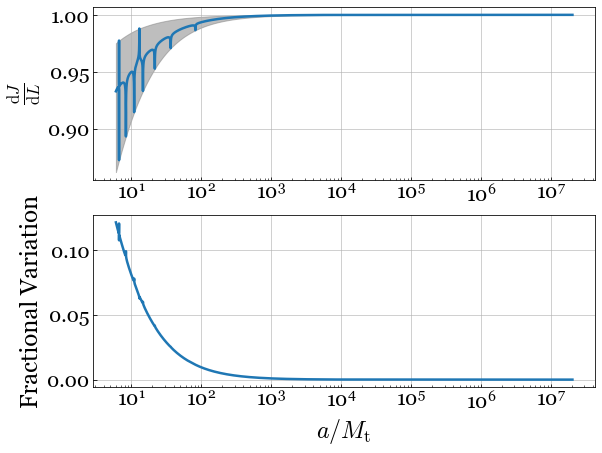

In [44]:
fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(aa/r_Mt, dJdL, label=r'$<\frac{\textrm{d}J}{\textrm{d}L}>$')
ax.fill_between(aa/r_Mt, dJdLp, dJdLm, color='tab:grey', alpha=0.5)
ax.set_ylabel(r'$\frac{{\rm d}J}{{\rm d}L}$')
ax.set_xscale('log')
# ax.set_ylim([0.9, 1.])

ax=fig.add_subplot(212)
ax.plot(aa/r_Mt, (dJdLm-dJdLp)/dJdL)
ax.set_xscale('log')
ax.set_ylabel('Fractional Variation')
ax.set_xlabel(r'$a/M_{\rm t}$')

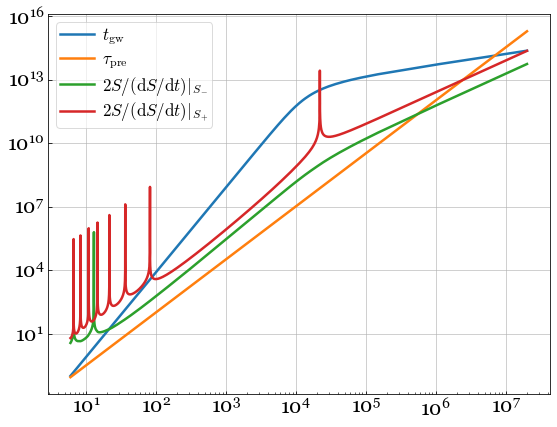

In [48]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.loglog(aa/r_Mt, t_gw, label=r'$t_{\rm gw}$')
ax.loglog(aa/r_Mt, t_pre, label=r'$\tau_{\rm pre}$')
ax.loglog(aa/r_Mt, t_pre_m, label=r'$S/({\rm d}S/{\rm d}t)|_{S_-}$')
ax.loglog(aa/r_Mt, t_pre_p, label=r'$S/({\rm d}S/{\rm d}t)|_{S_+}$')
ax.legend()

In [3]:
def evol_aLe(t_nat, y_nat_vect, par_aLe):
    a_nat, L_nat, e_orb = y_nat_vect
    M1, M2, t_unit, a_unit, L_unit = par_aLe

    Mt=M1+M2
    mu=M1*M2/Mt
    
    a_orb = a_nat*a_unit
    L_orb = L_nat * L_unit
    eff = np.sqrt(1.-e_orb**2.)
    
    G3_c5 = G**3./c**5.
    e2 = e_orb**2.
    e4 = e_orb**4.
    da = - (64./5.*G3_c5) * (mu*(M1+M2)**2./(a_orb**3.))\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3_c5*np.sqrt(G)) * mu**2.*(M1+M2)**2.5 / (a_orb**3.5) \
          * (1.+0.875*e2)/(eff**4.)
    de = - (304./15.*G3_c5) * mu*(M1+M2)**2.*e_orb/(a_orb**4.)\
          * (1.+121./304.*e2)/(eff**5.)
    
    dy_nat_vect = np.array([\
        da/a_unit, dL/L_unit, de])*t_unit
    return dy_nat_vect

def evol_log_aL(t_nat, logy_vect, par_aL):
    loga, logL = logy_vect
    M1, M2, t_unit= par_aL
    Mt=M1+M2
    mu=M1*M2/Mt
    
    a_orb = np.exp(loga)
    L_orb = np.exp(logL)
    eff = L_orb/(mu*np.sqrt(G*Mt*a_orb))
    e_orb = np.sqrt(1.-eff**2.)
    
    G3_c5 = G**3./c**5.
    e2 = e_orb**2.
    e4 = e_orb**4.
    
    da = - (64./5.*G3_c5) * (mu*(M1+M2)**2./(a_orb**3.))\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3_c5*np.sqrt(G)) * mu**2.*(M1+M2)**2.5 / (a_orb**3.5) \
          * (1.+0.875*e2)/(eff**4.)
    
    dlogy_vect = np.array([da/a_orb, dL/L_orb]) * t_unit
    return dlogy_vect

In [10]:
def get_inst_t_gw_from_a_orb(M1, M2, a_orb, e):
    Mt=M1+M2
    mu=M1*M2/(M1+M2)
    inv_t_gw = (64./5.)*(G**3./c**5.)*mu*Mt**2./a_orb**4. \
                * (1.+73./24.*e**2+37./96.*e**4.)/(1.-e**2.)**(3.5)
    t_gw = 1./inv_t_gw
    return t_gw

def get_angles(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    
    c_th1 = 0.5 * 1./((1.-qq)*S1) * \
        ((J**2. - L**2. - S**2.)/L  - 2.*qq*G*Mt**2./c*chi_eff/(1.+qq))
    c_th2 = 0.5 * qq/((1.-qq)*S2) * \
        (-(J**2.-L**2.-S**2.)/L + 2.*G*Mt**2./c*chi_eff/(1.+qq))
    c_th12 = (S**2. - S1**2. -S2**2.)/(2.*S1*S2)
    
    th1, th2, th12 = np.arccos(c_th1), np.arccos(c_th2), np.arccos(c_th12)
    c_dphi = (c_th12 - c_th1*c_th2)/(np.sin(th1) * np.sin(th2))
    dphi = np.arccos(c_dphi)
    return th1, th2, th12, dphi

def get_dSdt(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    mu=M1*M2/Mt
    eta=mu/Mt
    eff = np.sqrt(1.-e**2.)
    
    th1, th2, th12, dphi = get_angles(J, L, e, S, par)
    
    dSdt = 1.5*eta**6. * eff**3. * (1-qq**2.)/qq * ((G*Mt**2./c)/L)**5.\
        * (c**3./G/Mt) * (S1*S2/S)\
        * (-1. + 0.5*qq/(1.-qq)**2.*(J**2.-L**2.-S**2.)/L**2. \
          - 2.*qq**2./(1.-qq**2.)**2.*G*Mt**2./c/L*chi_eff)\
        * np.sin(th1) * np.sin(th2) * np.sin(dphi)
    return dSdt

def find_Smp(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    # note here is S vs chi-chi_eff!
    chi_vs_S_func1 = interp.interp1d(S_vect, chi_vect1-chi_eff)
    chi_vs_S_func2 = interp.interp1d(S_vect, chi_vect2-chi_eff)
    
    idx1 = np.argmin(chi_vect1)
    idx2 = np.argmax(chi_vect2)
    
    if np.max(chi_vect1) < chi_eff:
        Sm = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
        Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
    elif np.min(chi_vect2) > chi_eff:
        Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        Sp = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
    else:
        try:
            Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        except ValueError:
            Sm = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
        try:
            Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
        except ValueError:
            Sp = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
            
    if Sm>Sp:
        Sm, Sp = Sp, Sm
    return Sm, Sp

def find_S_chi_contour(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    return S_vect, chi_vect1, chi_vect2
    

def get_tau_pre(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par

    Sm, Sp = find_Smp(J, L, e, par)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = get_dSdt(J, L, e, S_vect, par)
    tau_pre = 2.*integ.trapz(1./np.abs(dSdt_vect), S_vect)
    return tau_pre 

def evol_J_avg(L_nat, J_nat, e_vs_L_func, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    mu=M1*M2/Mt
    eta = M1*M2/Mt**2.
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    L=L_nat * S_Mt
    J=J_nat * S_Mt
    
    e_orb = e_vs_L_func(L)
    a_orb = L**2./(G*mu**2.*Mt*(1.-e_orb**2.))
    
    t_gw = get_inst_t_gw_from_a_orb(M1, M2, a_orb, e_orb)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    inv_t_pre = np.abs(dSdt_vect/(S_vect+1.e-9*np.ones(nPt)*S_Mt))
    if np.min(inv_t_pre)<(1./t_gw):
        idx = np.argmin(inv_t_pre)
        S = S_vect[idx]
        c_th_L = (J**2.+L**2.-S**2.)/(2*J*L)
        dJdL = c_th_L
    else:
        c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
        tau = 2.*integ.trapz(S_Mt/dSdt_vect, S_vect/S_Mt)
        dJdL = 2./tau * integ.trapz(S_Mt*c_th_L/dSdt_vect, S_vect/S_Mt)
    return dJdL

def evol_J_avg_backup(L_nat, J_nat, e_vs_L_func, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    mu=M1*M2/Mt
    eta = M1*M2/Mt**2.
    
    S_unit = G*Mt**2./c
    L=L_nat * S_unit
    J=J_nat * S_unit
    
    e_orb = e_vs_L_func(L)
    a_orb = L**2./(G*mu**2.*Mt*(1.-e_orb**2.))
    r_unit = G*Mt/c**2.
    t_unit = np.sqrt(a_orb**3./(G*Mt))/eta * (a_orb/r_unit)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    
    c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    idx=(dSdt_vect/S_unit*t_unit) < 1.e-6
    dSdt_vect[idx] = np.inf * np.ones(len(dSdt_vect[idx]))
    
    tau = 2.*integ.trapz(S_unit/dSdt_vect, S_vect/S_unit)
    
    dJdL = 2./tau * integ.trapz(S_unit*c_th_L/dSdt_vect, S_vect/S_unit)
    return dJdL

def my_dJdL_integrator(dJdL_nat_func, L_nat_vect, J_nat_init):
    J_nat_vect = np.zeros(len(L_nat_vect))
    J_nat_vect[0] = J_nat_init
    
    for i in range(len(L_nat_vect)-1):
        LL = L_nat_vect[i]
        JJ = J_nat_vect[i]
        dL = L_nat_vect[i+1]-L_nat_vect[i]
        
        dJ_nat = dJdL_nat_func(LL, JJ)*dL
        J_nat_vect[i+1] = J_nat_vect[i] + dJ_nat
        
    return J_nat_vect

In [5]:
M1, M2 = 30.*Ms, 20.*Ms
Mt=(M1+M2)
mu=M1*M2/Mt
qq=M2/M1
eta=mu/Mt

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c

chi1, chi2=0.7, 0.7
S1 = chi1*G*M1**2./c
S2 = chi2*G*M2**2./c

In [6]:
chi_eff=0.00237398066724518

a_init = 10.*AU
e_init = 0.9994755828054394
L_init = 38.49467592859119 * S_Mt
J_init= 38.49800158044044 * S_Mt

t_gw = (64./5.)*(G**3./c**5.)*mu*Mt**2./a_init**4. \
        * (1.+73./24.*e_init**2+37./96.*e_init**4.)/(1.-e_init**2.)**(3.5)
t_gw = 1./t_gw

t_unit = t_gw
a_unit = a_init
L_unit = L_init

par_aLe = np.array([M1, M2, t_unit, a_unit, L_unit])
par_aL = np.array([M1, M2, t_unit])

y_nat_init = np.array([a_init/a_unit, L_init/L_unit, e_init])
logy_init = np.array([np.log(a_init), np.log(L_init)])

In [7]:
def terminator(t_nat, y_nat_vect, par_aLe):
    a_nat, L_nat, e_orb = y_nat_vect
    M1, M2, t_unit, a_unit, L_unit = par_aLe

    a_orb = a_nat*a_unit
    resi = (a_orb - 3.*r_Mt)/a_unit
    return resi

term_func=lambda t_nat_, y_nat_vect_:terminator(t_nat_, y_nat_vect_, par_aLe)
term_func.direction = -1
term_func.terminal = True

int_func=lambda t_nat_, y_nat_vect_:\
    evol_aLe(t_nat_, y_nat_vect_, par_aLe)
    
sol0=integ.solve_ivp(int_func, \
        t_span=(0, 30), y0=y_nat_init, rtol=3e-14, atol=1e-14, \
        events=term_func)

def terminator(t_nat, logy_vect, par_aL):
    loga, logL = logy_vect
    M1, M2, t_unit = par_aL

    a_orb = np.exp(loga)
    resi = (a_orb/r_Mt - 3.)
    return resi

term_func=lambda t_nat_, logy_vect_:terminator(t_nat_, logy_vect_, par_aL)
term_func.direction = -1
term_func.terminal = True

int_func=lambda t_nat_, logy_vect_:\
    evol_log_aL(t_nat_, logy_vect_, par_aL)
    
sol1=integ.solve_ivp(int_func, \
        t_span=(0, 30), y0=logy_init, rtol=3e-14, atol=1e-14, \
        events=term_func)

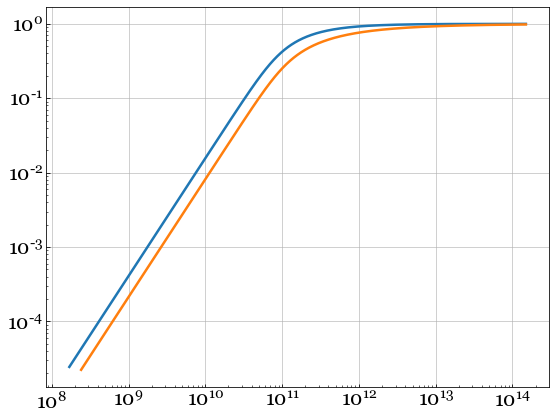

In [8]:
t0=sol0.t * t_unit
a_orb0 = sol0.y[0, :]*a_unit
L_orb0 = sol0.y[1, :]*L_unit
e_orb0 = sol0.y[2, :]

t1=sol1.t * t_unit
a_orb1 = np.exp(sol1.y[0, :])
L_orb1 = np.exp(sol1.y[1, :])
eff_orb1 = L_orb1/(mu*np.sqrt(G*Mt*a_orb1))
e_orb1 = np.sqrt(1.-eff_orb1)

loge_vs_logL_tck0 = interp.splrep(np.log(L_orb0[::-1]), np.log(e_orb0[::-1]))
logL_vs_loga_tck0 = interp.splrep(np.log(a_orb0[::-1]), np.log(L_orb0[::-1]))
e_vs_L_func0=lambda LL: np.exp(interp.splev(np.log(LL), loge_vs_logL_tck0))
L_vs_a_func0=lambda aa: np.exp(interp.splev(np.log(aa), logL_vs_loga_tck0))

loge_vs_logL_tck1 = interp.splrep(np.log(L_orb1[::-1]), np.log(e_orb1[::-1]))
logL_vs_loga_tck1 = interp.splrep(np.log(a_orb1[::-1]), np.log(L_orb1[::-1]))
e_vs_L_func1=lambda LL: np.exp(interp.splev(np.log(LL), loge_vs_logL_tck1))
L_vs_a_func1=lambda aa: np.exp(interp.splev(np.log(aa), logL_vs_loga_tck1))

fig=plt.figure()
ax=fig.add_subplot(111)
ax.loglog(a_orb0, e_orb0)
ax.loglog(a_orb1, e_orb1)

In [9]:
par_JL = np.array([M1, M2, S1, S2, chi_eff])
int_func=lambda L_nat_, J_nat_:\
    evol_J_avg(L_nat_, J_nat_, e_vs_L_func1, par_JL)

L_1kM_1 = L_vs_a_func1(1000.*r_Mt)
L_nat_vect = np.linspace(L_init/S_Mt, L_1kM_1/S_Mt, 1e4)
print(L_nat_vect[0], L_nat_vect[-1])

J_nat_vect = my_dJdL_integrator(int_func, L_nat_vect, J_init/S_Mt)

38.49467592859119 7.589272945259946


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:157: RuntimeWarning: divide by zero encountered in double_scalars
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:157: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
idx = np.isfinite(J_nat_vect)
print(L_nat_vect[idx][-1], J_nat_vect[idx][-1])

25.64910589171504 25.65292283491915


In [66]:
LL_test=25.64910589171504 * S_Mt
JJ_test=25.65292283491915 * S_Mt
e_test =e_vs_L_func1(LL_test)
print(e_test)

S_vect, chi_vect1, chi_vect2=find_S_chi_contour(JJ_test, LL_test, e_test, par_JL)
Sm, Sp = find_Smp(JJ_test, LL_test, e_test, par_JL)
print(Sm/S_Mt, Sp/S_Mt)

# fig=plt.figure()
# ax=fig.add_subplot(111)
# ax.plot(S_vect/S_Mt, chi_vect1)
# ax.plot(S_vect/S_Mt, chi_vect2)
# ax.axhline(chi_eff, ls=':', color='grey')

0.23609090968646693
0.00237398066724518
0.14003012341258217 0.3639999911630099


In [11]:
par_JL = np.array([M1, M2, S1, S2, chi_eff])

L_1kM_0 = L_vs_a_func0(1000.*r_Mt)
e_1kM_0 = e_vs_L_func0(L_1kM_0)
int_func=lambda L_nat_, J_nat_:\
    evol_J_avg(L_nat_, J_nat_, e_vs_L_func0, par_JL)
sol0=integ.solve_ivp(int_func, \
    t_span=(L_init/S_Mt, L_1kM_0/S_Mt), y0=np.array([J_init/S_Mt]), rtol=1e-10, atol=1e-10)

L_1kM_1 = L_vs_a_func1(1000.*r_Mt)
e_1kM_1 = e_vs_L_func1(L_1kM_1)
int_func=lambda L_nat_, J_nat_:\
    evol_J_avg(L_nat_, J_nat_, e_vs_L_func1, par_JL)
sol1=integ.solve_ivp(int_func, \
    t_span=(L_init/S_Mt, L_1kM_1/S_Mt), y0=np.array([J_init/S_Mt]), rtol=1e-10, atol=1e-10)

In [15]:
L_1kM_ref = mu * np.sqrt(G*Mt*1000.*r_Mt)

print(L_1kM_1/L_1kM_0, L_1kM_0/L_1kM_ref, L_1kM_1/L_1kM_ref)
print(e_1kM_0, e_1kM_1)


0.6836082175602363 1.4627888993547864 0.9999745121548255
0.009667267357489595 0.005048548822083564


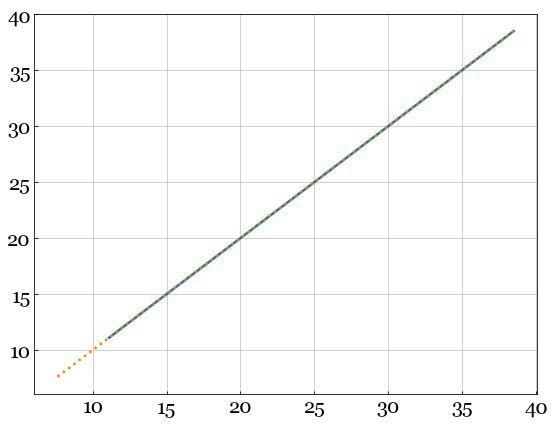

In [13]:
L0, J0=sol0.t, sol0.y[0, :]
L1, J1=sol1.t, sol1.y[0, :]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(L0, J0)
ax.plot(L1, J1, ls=':')

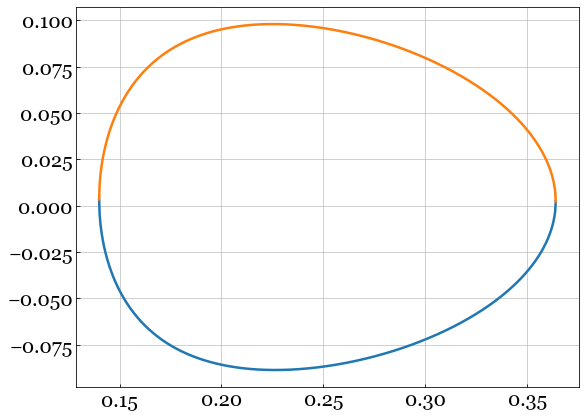

In [48]:
S_vect, chi_vect1, chi_vect2 = find_S_chi_contour(J0[-1]*S_Mt, L0[-1]*S_Mt, e_vs_L_func0(L_1kM_0), par_JL, nPt=1000)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(S_vect/S_Mt, chi_vect1)
ax.plot(S_vect/S_Mt, chi_vect2)

In [51]:
np.argmin([1,1,3])

0